In [1]:
from Module.config import get_cfg_defaults

cfg = get_cfg_defaults()

In [2]:
print(cfg.DATASET.CLASS_MAP)
print(cfg.DATASET.HIST_NAME)
class_map = {ele[0]: ele[1] for ele in cfg.DATASET.CLASS_MAP}

[[225, 0, 1, 'background'], [56, 1, 2, 'inflammatory infiltration'], [43, 2, 1, 'adipose tissue'], [53, 3, 1, 'sweat gland'], [45, 4, 2, 'hair follicles'], [42, 5, 1, 'dermis'], [54, 6, 1, 'sebaceous gland'], [41, 7, 2, 'epidermis'], [202, 8, 1, 'skeletal muscle'], [55, 9, 1, 'blood vessels']]
['background', 'inflammatory infiltration', 'adipose tissue', 'sweat gland', 'hair follicles', 'dermis', 'sebaceous gland', 'epidermis', 'skeletal muscle', 'blood vessels']


In [3]:
class_map

{225: 0, 56: 1, 43: 2, 53: 3, 45: 4, 42: 5, 54: 6, 41: 7, 202: 8, 55: 9}

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [ ]:
import os
from Module.model import return_resnet
from hephaestus.data.ndpwrapper_v2 import Slide_ndpread
from skimage.color import rgb2hsv
import numpy as np
import time

In [ ]:
SLIDE_LIST = [
"2019-10-30 02.05.46.ndpi",
"2019-10-30 02.04.50.ndpi",
"2019-10-30 02.09.05.ndpi",
"2019-10-30 02.07.27.ndpi",
"2019-10-30 02.10.47.ndpi",
"2019-10-30 02.14.37.ndpi",
"2019-10-30 02.18.03.ndpi",
"2019-10-30 02.19.24.ndpi",
"2019-10-30 02.15.32.ndpi",
"2019-10-30 02.23.07.ndpi",
"2019-10-30 01.59.42.ndpi",
"350013D01170 - 2019-10-30 02.21.40.ndpi",
"2019-10-30 02.01.19.ndpi",
"2019-10-30 02.02.21.ndpi",
"2019-10-30 02.03.40.ndpi",
"2019-10-30 02.05.46.ndpi"]

In [5]:
# load weight from model
checkpoint_dir  = "/workspace/skin/checkpoint/"
reload_file = "R-101-v1_512_E50_cls10_AUG.h5"
checkpoint_path = checkpoint_dir+reload_file

# reload model
model = return_resnet("R-101-v1", classNum=len(class_map), in_shape=cfg.DATASET.INPUT_SHAPE)
model.load_weights(checkpoint_path)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [67]:
class SlidePredictor:
    def __init__(self, 
                 bbox_shape, 
                 slide_dir,
                 slide_name,
                 histologic_name,
                 classifier,
                 class_map,
                 batch_size=32,
                 fast=True,
                 five_crop = True,
                ):
        self.bbox_shape = bbox_shape
        self.slide_dir  = slide_dir
        self.slide_name = slide_name
        self.histologic_name = histologic_name
        self.classifier = classifier
        self.batch_size = batch_size
        self.five_crop  = five_crop
        self.colormap   = [(1, 1, 1),
                           (0.7098039215686275, 0.5333333333333333, 0.09411764705882353), 
                           (1.0, 0.3411764705882353, 0.13333333333333333), 
                           (0.9137254901960784, 0.11764705882352941, 0.38823529411764707), 
                           (0.803921568627451, 0.8627450980392157, 0.2235294117647059), 
                           (0.0, 0.0, 0.6), 
                           (0.2980392156862745, 0.6862745098039216, 0.3137254901960784), 
                           (0.611764705882353, 0.15294117647058825, 0.6901960784313725), 
                           (0.011764705882352941, 0.6627450980392157, 0.9568627450980393), 
                           (1, 0, 0),
                           (0.7098039215686275, 0.5333333333333333, 0.09411764705882353)
                           ]
        self.class_map=class_map

        self.this_slide = Slide_ndpread(os.path.join(slide_dir, slide_name))
        W, H = self.this_slide.get_size()
        w, h = bbox_shape[0], bbox_shape[1]
        self.W = W
        self.H = H
        
        self.w_stride = W//w if W%w==0 else W//w+1
        self.h_stride = H//h if H%h==0 else H//h+1
        self.prob_map = np.zeros((self.w_stride, self.h_stride, len(self.class_map)), dtype=np.float32)
        
        assert W//w*w <= W and H//h*h <= H
        self.tiny_slide = self.this_slide.get_patch_with_resize(coord=(0,0),
                                                                src_sz = (W//w*w, H//h*h),
                                                                dst_sz = (W//w, H//h)
                                                               )
        self.tiny_slide = np.pad(self.tiny_slide, 
                                 ((0, self.h_stride-self.tiny_slide.shape[0]),
                                  (0, self.w_stride-self.tiny_slide.shape[1]), 
                                  (0, 0)), 
                                 mode="reflect")
        self.background_mask = np.zeros((self.h_stride, self.w_stride))
        self.fast = fast
        if fast:
            self.background_mask = self._judge_bg()
        self._get_prob_map()
        self._class_heatmap = np.argmax(self.prob_map, axis=-1)
    
    def _judge_bg(self, expand=True):
        hsv_img = rgb2hsv(self.tiny_slide)
        saturation_img = hsv_img[:, :, 1]
        boolean_mask = np.array(saturation_img<0.05, dtype=np.int32)
        if not expand:
            return boolean_mask
        for w in range(boolean_mask.shape[1]):
            meet = 0
            for h in range(boolean_mask.shape[0]):
                if boolean_mask[h, w] == 0:
                    meet = 2
                elif meet > 0:
                    boolean_mask[h, w] = 0
                    meet -= 1
            meet = 0
            for h in range(boolean_mask.shape[0])[::-1]:
                if boolean_mask[h, w] == 0:
                    meet = 2
                elif meet > 0:
                    boolean_mask[h, w] = 0
                    meet -= 1
        return boolean_mask
        
    def crop(self, x, y):
        # perform five crop at coordinate x, y (left-upper vertex)
        # return: 5 np-image list[center, LUQ, RUQ, LLQ, RLQ]
        patch_size = self.bbox_shape[0]
        dirs = [(0, 0), (-patch_size//2, -patch_size//2), (patch_size//2, -patch_size//2), (-patch_size//2, patch_size//2), (patch_size//2, patch_size//2)]
        ret = []
        for dx, dy in dirs:
            ret.append(self.this_slide.get_patch_at_level((x+dx, y+dy), self.bbox_shape)/255.)
        return ret

    def _get_prob_map(self):
        # 277*76
        patches = []
        coords  = []

        for i in range(self.w_stride):
            begin_time = time.time()
            for j in range(self.h_stride):
                if self.fast and self.background_mask[j, i] != 0:
                    continue
                else:
                    try:
                        # if the slide ndpi file is corrupted, getting some patches may raise error
                        if self.five_crop:
                            patch = self.crop(self.bbox_shape[0]*i, self.bbox_shape[1]*j)
                        else:
                            patch = self.this_slide.get_patch_at_level((512*i, 512*j), 
                                                                       self.bbox_shape)/255.
                    except:
                        self.background_mask[j, i] = 1
                    if not self.fast:
                        saturation = rgb2hsv(patch[0] if self.five_crop else patch)[..., 1].mean()
                        if saturation < 0.05:
                            self.background_mask[j, i] = 1
                if self.background_mask[j, i] == 0:
                    if isinstance(patch, list):
                        patches.extend(patch)
                        coords.extend([(i, j) for k in range(len(patch))])
                    else:
                        patches.append(patch)
                        coords.append((i, j))
                    if len(patches) >= self.batch_size:
                    #if len(patches)%self.batch_size==self.batch_size-1:
                        preds = self.classifier(np.array(patches, dtype=np.float32)).numpy()
                        if self.five_crop:
                            for idx, coord in enumerate(coords[::5]):
                                self.prob_map[coord[0], coord[1]] = np.copy(np.mean(preds[5*idx:5*(idx+1)], axis=0))
                        else:
                            for idx, coord in enumerate(coords):
                                self.prob_map[coord[0], coord[1]] = np.copy(preds[idx])
                        patches.clear()
                        coords.clear()
            end_time = time.time()
            print("Column {:}/{:}: time elapse {:}".format(i, self.w_stride, end_time-begin_time), end='\r')
        
        if len(patches):
            preds = self.classifier(np.array(patches, dtype=np.float32)).numpy()
            if self.five_crop:
                for idx, coord in enumerate(coords[::5]):
                    self.prob_map[coord[0], coord[1]] = np.copy(np.mean(preds[5*idx:5*(idx+1)], axis=0))
            else:
                for idx, coord in enumerate(coords):
                    self.prob_map[coord[0], coord[1]] = np.copy(preds[idx])
            patches.clear()
            coords.clear()
        self.prob_map[self.background_mask.transpose().astype(bool), 0] = 1
    
    def _postprocess(self):
        '''
        Handle adipose tissue that is adjacent to epidermis
        '''
        adipose_mask = np.where(self._class_heatmap == 2)
            
    def visualize_predict(self, axis):
        predicted_cls = np.argmax(self.prob_map, axis=-1)
        # heatmap in shape[h, w, 3]
        heatmap = np.zeros((predicted_cls.shape[1], predicted_cls.shape[0], 3))
        for w in range(predicted_cls.shape[0]):
            for h in range(predicted_cls.shape[1]):
                heatmap[h, w] = np.array(self.colormap[int(predicted_cls[w][h])])
        heatmap = 0.5*heatmap + 0.5*self.tiny_slide/255.
        axis.imshow(heatmap)
    
    def get_np_pred(self):
        '''
        self.prob_map is in shape (w, h, 10)
        however, the PRP run session require flattened (h, w)
        '''
        return self.prob_map.transpose((1,0,2)).reshape((-1, self.prob_map.shape[2]))

In [68]:
myPredictor = SlidePredictor(bbox_shape=cfg.DATASET.INPUT_SHAPE[:2],
                             slide_dir = "/mnt/cephrbd/data/A19001_NCKU_SKIN/Image/20191106/",
                             slide_name = SLIDE_LIST[6],#"2019-10-30 02.02.21.ndpi",
                             histologic_name = cfg.DATASET.HIST_NAME,
                             classifier = model,
                             class_map = class_map
                            )

Width: 126720 , Height: 46080


In [69]:
print(myPredictor.background_mask.T.shape) # 248, 90
print(myPredictor.prob_map.shape)

(248, 90)
(248, 90, 10)


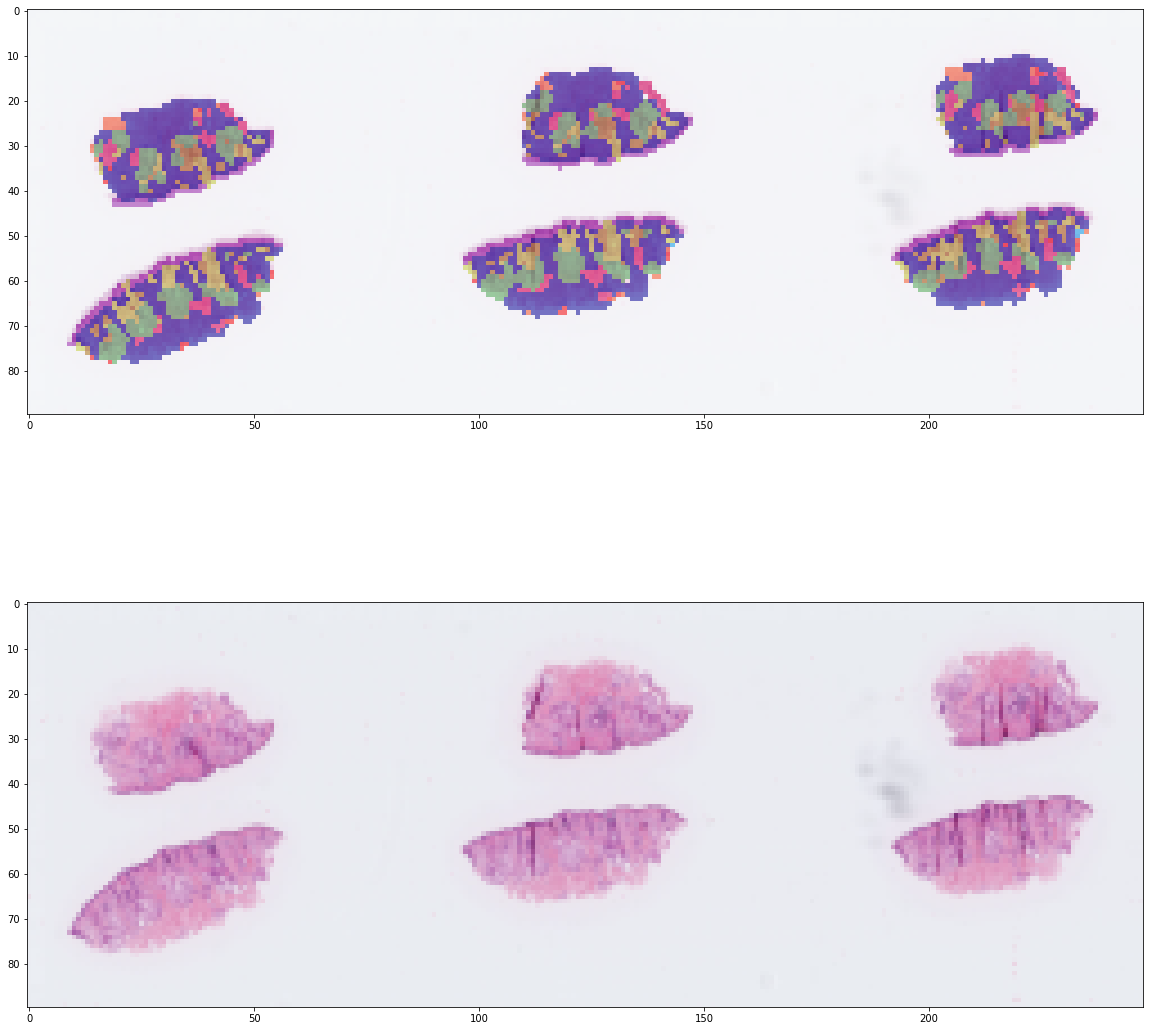

In [70]:
import matplotlib.pyplot as plt

show_idx = 0
fig1 = plt.figure(figsize = (20, 20))
ax = fig1.add_subplot(2,1,1)

myPredictor.visualize_predict(ax)
plt.gca().set_aspect('equal', adjustable='box')

ax = fig1.add_subplot(2,1,2)
ax.imshow(myPredictor.tiny_slide)
#plt.savefig("result/02.23.07_result.png")
plt.show()

In [47]:
test_sum = myPredictor.prob_map.sum(axis=-1)
print(test_sum)

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.     

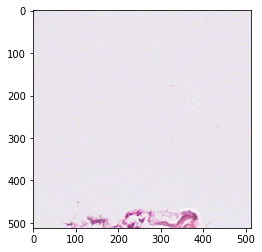

0.04577453949176705

In [115]:
patch = myPredictor.this_slide.get_patch_at_level(coord=(125 * 512, 12 * 512), sz=(512, 512))
plt.imshow(patch)
plt.show()

s = rgb2hsv(patch)[..., 1]
s.mean()

(array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65]),)


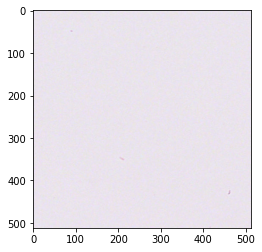

Patch saturation:  0.040715659995216494
(90, 248)
Tiny slide saturation:  0.2564102564102564


In [126]:
idxs = np.where(myPredictor.background_mask[:, 125] == 0)
print(idxs)
choosen_idx = 46
patch = myPredictor.this_slide.get_patch_at_level(coord=(125 * 512, choosen_idx * 512), sz=(512, 512))
plt.imshow(patch)
plt.show()

s = rgb2hsv(patch)[..., 1]
print("Patch saturation: ", s.mean())

hsv_img = rgb2hsv(myPredictor.tiny_slide)
saturation_img = hsv_img[:, :, 1]
print(saturation_img.shape)
print("Tiny slide saturation: ", saturation_img[choosen_idx, 125])

In [66]:
dirs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
visit = np.zeros(myPredictor._class_heatmap.shape[:2])
meet_epi = np.zeros(myPredictor._class_heatmap.shape[:2])
meet_bg  = np.zeros(myPredictor._class_heatmap.shape[:2])
meet_oth = np.zeros(myPredictor._class_heatmap.shape[:2])

def dfs(x, y, boundary):
    if visit[x, y]: 
        return
    visit[x, y] = 1
    for dx, dy in dirs:
        if not (x+dx >= 0 and y+dy >= 0 and x+dx < boundary[0] and y+dy < boundary[1]):
            continue
        print(graph[x+dx, y+dy], end='')
        if graph[x+dx, y+dy] == 8: #bg
            meet_bg[x, y] = 1
        elif graph[x+dx, y+dy]==4 or graph[x+dx, y+dy] == 7:# epidermis and hair follicles
            meet_epi[x, y] = 1
        elif graph[x+dx, y+dy] != 2:
            meet_oth[x, y]= 1
        elif graph[x+dx, y+dy] == 2:
            dfs(x+dx, y+dy, boundary)
            meet_epi[x, y] = max(meet_epi[x+dx, y+dy], meet_epi[x, y])
            meet_bg [x, y] = max(meet_bg [x+dx, y+dy], meet_epi[x, y])
            meet_oth[x, y] = max(meet_oth[x+dx, y+dy], meet_epi[x, y]) 

    
adipose_mask_x, adipose_mask_y = np.where(myPredictor._class_heatmap == 2)
graph = myPredictor._class_heatmap

for i in range(len(adipose_mask_x)):
    x, y = adipose_mask_x[i], adipose_mask_y[i]
    assert graph[x, y] == 2
    dfs(x, y, boundary=graph.shape)
print("\nmeet epithelium: ",np.where(meet_epi>0))
print("meet background: ",np.where(meet_bg>0))
print("meet others: "    ,np.where(meet_oth>0))

02222220050505050222222222272202022222222200407070702424040404045465555530305222222005050505555253235225625525650000
meet epithelium:  (array([125, 126, 127, 128, 129, 129, 130, 130, 131, 132, 133, 134]), array([46, 46, 46, 46, 46, 59, 45, 46, 45, 45, 45, 45]))
meet background:  (array([125, 126, 127, 128, 129, 130, 130, 131, 132, 133]), array([46, 46, 46, 46, 46, 45, 46, 45, 45, 45]))
meet others:  (array([125, 125, 126, 126, 127, 127, 128, 128, 129, 129, 129, 129, 129,
       130, 130, 130, 130, 130, 131, 131, 132, 132, 132, 132, 133, 133,
       133, 133, 134]), array([12, 46, 12, 46, 12, 46, 12, 46, 45, 46, 59, 61, 64, 13, 16, 17, 45,
       46, 13, 45, 13, 45, 60, 65, 13, 45, 60, 61, 45]))


[    0     3     3    19    21    21   177  2640 20017  2551  2400  1576
   317  1300  1292  1057   798   684   337   237   335   315   236   184
   117   138   142   120    98    85   105   114    92    76   108    90
   116    85    91    81   117    88   100   113   101   128    98    99
   133   121   131   148   141   161   168   126   152   167   134   173
   170   151   143   134   175   157   144   120   113   161   103    97
   124   108   117   104    92    87   120    94    92    91    77    89
    58    92    80    66    62    62    70    73    58    50    52    52
    41    43    42    26    34    28    22    20    13    15    19    24
    12    16    10    10     5    10     4     6     6     3     5     4
     5     4     3     0     3     1     1     4     2     6     1     1
     0     0     2     1     2     3     1     0     0     0     0     0
     0     1     1     0     0     0     0     0     1     2     0     0
     0     0     0     0     1     0     0     0   

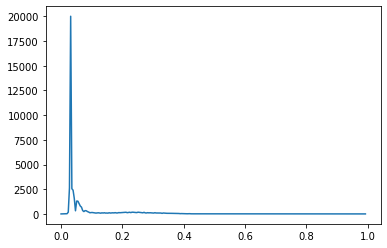

In [9]:
hsv = (rgb2hsv(myPredictor.tiny_slide)[:,:,1]*255).astype(np.int32)
hist, bins = np.histogram(hsv, np.arange(255))
print(hist)
plt.plot(np.arange(254)/255., hist)
plt.show()

## Compute AUC, ROC

In [10]:
from Module.util import *
from Module.dataloader import DataLoader, SlideDataSet
import json

valid_histogram = {}
valid_slides=cfg.DATASET.VALID_SLIDE
class_map  = get_class_map(cfg.DATASET.CLASS_MAP)
with open(cfg.DATASET.JSON_PATH) as f:
    data = json.load(f)
    for key, val in data.items():
        targets = data[key]['targets']
        if key+".ndpi" in valid_slides:
            collect_histogram(targets, valid_histogram, interest=cfg.DATASET.INT_TO_CLASS)

upsample = 4 if cfg.DATASET.INPUT_SHAPE[0] == 256 else 1
valid_frequency = get_frequency_dict(valid_histogram, upsample=upsample)
print(valid_frequency)


valid_datasets=[SlideDataSet(slide_path=cfg.DATASET.SLIDE_DIR,
                                     slide_name=cfg.DATASET.VALID_SLIDE[i],
                                     label_path=cfg.DATASET.JSON_PATH,
                                     frequency_dict=valid_frequency,
                                     class_map=class_map,
                                     patch_size=cfg.DATASET.INPUT_SHAPE[:2],
                                     interest = cfg.DATASET.INT_TO_CLASS,
                                     preproc=preproc_resnet if cfg.DATASET.PREPROC else None,
                                     augment=None,
                                     shuffle=False,
                                     num_worker=10,
                                     save_bbox = True) for i in range(len(cfg.DATASET.VALID_SLIDE))]
valid_loader = DataLoader(datasets=valid_datasets, 
                                  batch_size=cfg.MODEL.BATCH_SIZE, 
                                  num_slide=len(cfg.DATASET.VALID_SLIDE))

predictions = []
groundtruth = []
correct = 0
total   = 0

for data in valid_loader:
    imgs, labels = data
    predictions.append(model(imgs).numpy())
    groundtruth.append(labels)

{41: 4, 45: 5, 225: 15, 43: 16, 42: 17, 53: 17, 56: 10, 54: 17, 55: 26, 202: 30}
==============Loading bboxs==============
==============Loading bboxs==============
==============Loading bboxs==============


In [11]:
if type(predictions) is list:
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, predictions.shape[-1])
if type(groundtruth) is list:
    groundtruth = np.array(groundtruth)
    groundtruth = groundtruth.reshape(-1, groundtruth.shape[-1])
print(predictions.shape)
print(groundtruth.shape)
pred_cls = np.argmax(predictions, axis=-1)
grou_cls = np.argmax(groundtruth, axis=-1)
acc = np.sum(pred_cls == grou_cls)*1.0/predictions.shape[0]
print(f"Accuracy: {acc}")

(16320, 10)
(16320, 10)
Accuracy: 0.9126838235294118


In [12]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# y_test (n, 0 or 1) is groundtruth
# y_score (n, 0 ~ 1) is prediction
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(groundtruth[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

'''
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(groundtruth.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
'''

'\n# Compute micro-average ROC curve and ROC area\nfpr["micro"], tpr["micro"], _ = roc_curve(groundtruth.ravel(), predictions.ravel())\nroc_auc["micro"] = auc(fpr["micro"], tpr["micro"])\n'

In [13]:
print(cfg.DATASET.HIST_NAME)
print(fpr.keys())

['background', 'inflammatory infiltration', 'adipose tissue', 'sweat gland', 'hair follicles', 'dermis', 'sebaceous gland', 'epidermis', 'skeletal muscle', 'blood vessels']
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


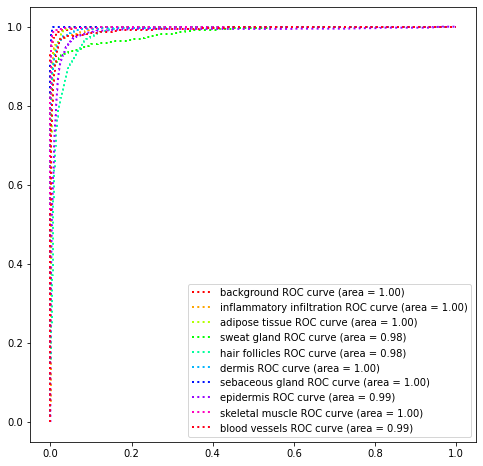

In [20]:
import matplotlib.pyplot as plt
n_classes = 10
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

'''
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
'''

# Plot all ROC curves
#cmap = plt.get_cmap('gnuplot')
cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, len(fpr))]

fig10 = plt.figure(figsize=(8, 8))
ax = fig10.add_subplot(1,1,1)
for i, key in enumerate(fpr.keys()):
    ax.plot(fpr[key], tpr[key],
         label=(cfg.DATASET.HIST_NAME[int(key)])+' ROC curve (area = {0:0.2f})'
               ''.format(roc_auc[key]),
         color=colors[i], linestyle=':', linewidth=2)
    ax.legend()
plt.savefig(f"result/{reload_file.split('.h')[0]+'AUC'}.png")
plt.show()

In [15]:
import pandas as pd
# compute accuracy
correct   = [0 for i in range(n_classes)]
incorrect = [0 for i in range(n_classes)]

for i in range(len(pred_cls)):
    if pred_cls[i] == grou_cls[i]:
        correct[grou_cls[i]] += 1
    else:
        incorrect[grou_cls[i]] += 1

total = [int(correct[i]+incorrect[i]) for i in range(len(correct))]
accuracy = [correct[i]*1./(total[i]) for i in range(len(correct))]

df = pd.DataFrame(np.array([correct, incorrect, total, accuracy]),
                 columns=[cfg.DATASET.HIST_NAME[i] for i in range(len(correct))])
print(df)

mask = [1 if pred_cls[i] == grou_cls[i] else 0 for i in range(grou_cls.shape[0])]
print("Total accuracy:", sum(mask)*1./len(grou_cls))

    background  inflammatory infiltration  adipose tissue  sweat gland  \
0  1517.000000                1515.000000     1495.000000    1440.0000   
1   107.000000                  80.000000      116.000000     184.0000   
2  1624.000000                1595.000000     1611.000000    1624.0000   
3     0.934113                   0.949843        0.927995       0.8867   

   hair follicles       dermis  sebaceous gland    epidermis  skeletal muscle  \
0     1315.000000  1499.000000       1607.00000  1446.000000      1567.000000   
1      323.000000   132.000000         23.00000   177.000000       113.000000   
2     1638.000000  1631.000000       1630.00000  1623.000000      1680.000000   
3        0.802808     0.919068          0.98589     0.890943         0.932738   

   blood vessels  
0    1494.000000  
1     170.000000  
2    1664.000000  
3       0.897837  
Total accuracy: 0.9126838235294118


Normalized confusion matrix
[[9.34113300e-01 0.00000000e+00 6.15763547e-04 0.00000000e+00
  0.00000000e+00 1.23152709e-03 0.00000000e+00 1.47783251e-02
  1.53940887e-02 3.38669951e-02]
 [0.00000000e+00 9.49843260e-01 6.26959248e-03 2.94670846e-02
  5.64263323e-03 6.26959248e-04 5.01567398e-03 0.00000000e+00
  0.00000000e+00 3.13479624e-03]
 [0.00000000e+00 9.93171943e-03 9.27995034e-01 2.60707635e-02
  3.10366232e-03 6.20732464e-04 1.24146493e-03 0.00000000e+00
  1.86219739e-03 2.91744258e-02]
 [0.00000000e+00 1.04679803e-02 0.00000000e+00 8.86699507e-01
  9.42118227e-02 3.07881773e-03 4.92610837e-03 0.00000000e+00
  0.00000000e+00 6.15763547e-04]
 [0.00000000e+00 6.10500611e-03 0.00000000e+00 1.83150183e-03
  8.02808303e-01 2.44200244e-03 9.76800977e-03 1.73382173e-01
  0.00000000e+00 3.66300366e-03]
 [6.13120785e-04 3.31085224e-02 2.45248314e-03 3.06560392e-03
  6.13120785e-03 9.19068056e-01 4.90496628e-03 7.35744942e-03
  0.00000000e+00 2.32985898e-02]
 [0.00000000e+00 9.20245399e-0

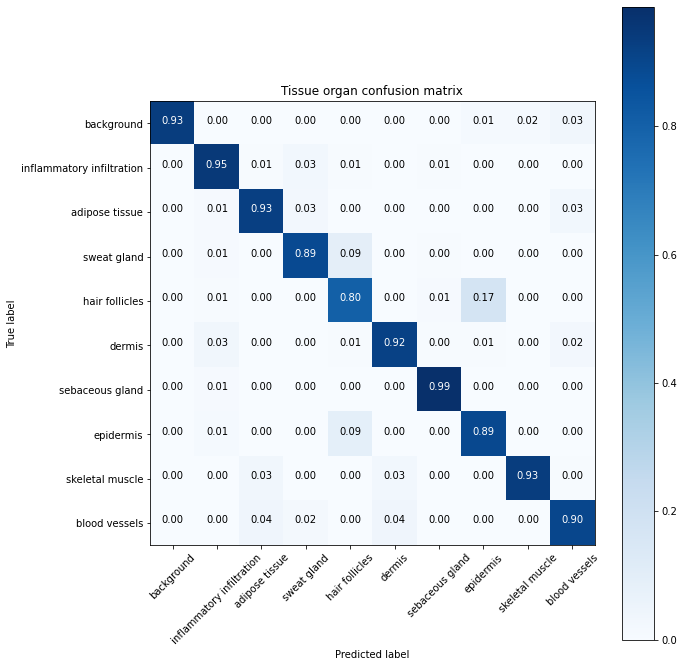

In [16]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# print confusion matrix
plt.figure(figsize=(10,10))
cnf_matrix = confusion_matrix(grou_cls, pred_cls)
plot_confusion_matrix(cnf_matrix, classes=[cfg.DATASET.HIST_NAME[i] for i in range(10)],normalize=True,
                    title="Tissue organ confusion matrix")

plt.savefig("result/R-101-confusion_matrix.png")
plt.show()

## Try export csv file from inference outcome

In [17]:
slide = "/mnt/cephrbd/data/A19001_NCKU_SKIN/Image/20191106/2019-10-30 02.23.07.ndpi"
slide = Slide_ndpread(slide)
W, H = slide.get_size()
print(W, H)
print(W//512, H//512)
patch = slide.get_patch_at_level((512*165, 512*70), (512, 512))

NameError: name 'Slide_ndpread' is not defined

In [34]:
from hephaestus.compose.wsi_patch.api import PatchResultPostprocess

In [35]:
PRP = PatchResultPostprocess(patch_size=512, raw_h=myPredictor.this_slide.get_size()[1]-512,
                             raw_w=myPredictor.this_slide.get_size()[0]-512, blur=0.)

In [36]:
myPredictor.this_slide.get_size()

(142080, 39168)

In [37]:
tmp = myPredictor.prob_map

print(tmp.shape)
back  = np.zeros((myPredictor.w_stride, myPredictor.h_stride, 1))
back[myPredictor.background_mask.transpose()] = 1
out = np.concatenate([tmp, back], axis=2)
print(out)

(278, 77, 8)
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+

In [38]:
out.shape

(278, 77, 9)

In [44]:
'''
root@80f26a2f0117:/workspace/skin# cd /mnt/cephrbd/data/A19001_NCKU_SKIN/Meta/
root@80f26a2f0117:/mnt/cephrbd/data/A19001_NCKU_SKIN/Meta# cat annot-pk-reference.json 
{
    "80": "Muscle",
    "56": "Inflammatory infiltration",
    "55": "Blood vessel",
    "54": "Sebaceous gland",
    "53": "Sweat gland",
    "45": "Hair follicle",
    "44": "Unspecified",
    "43": "Adipose tissue",
    "42": "Dermis (Collagen fiber and fibroblasts)",
    "41": "Epidermis"
}
'''
result_dir = "/workspace/skin/result/inference_CSV/"
target_folder= os.path.join(result_dir, "12345")
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
d = PRP.run(prediction=myPredictor.get_np_pred(),  
            result_dir=result_dir, target_folder=target_folder)
print(d)

{'slide_name': '12345', 'default_threshold': '0.700', 'tile_size': 512, 'meta_path': '/workspace/skin/result/inference_CSV/12345/df.csv', 'layer_map': {'0.100': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.100.png', 'score': 0}, '0.200': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.200.png', 'score': 0}, '0.300': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.300.png', 'score': 0}, '0.400': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.400.png', 'score': 0}, '0.500': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.500.png', 'score': 0}, '0.600': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.600.png', 'score': 0}, '0.700': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.700.png', 'score': 0}, '0.800': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.800.png', 'score': 0}, '0.900': {'path': '/workspace/skin/result/inference_CSV/

In [45]:
import pandas
d = pandas.read_csv(target_folder+"/df.csv")
d

,w,h,pred_as_0,pred_as_1,pred_as_2,pred_as_3,pred_as_4,pred_as_5,pred_as_6,pred_as_7,pred_as_8
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
21047,272,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21048,273,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21049,274,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21050,275,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [99]:
import matplotlib.image as mpimg

slide_list = [
"2019-10-30 01.59.42.",
"2019-10-30 02.01.19.",
"2019-10-30 02.02.21.",
"2019-10-30 02.03.40.",
"2019-10-30 02.04.50.",
"2019-10-30 02.05.46.",
"2019-10-30 02.07.27.",
"2019-10-30 02.09.05.",
"2019-10-30 02.10.47.",
"2019-10-30 02.14.37.",
"2019-10-30 02.15.32.",
"2019-10-30 02.18.03.",
"2019-10-30 02.19.24.",
"2019-10-30 02.23.07.",
"350013D01170 - 2019-10-30 02.21.40."   
]

def plot_threshold(fig, slide_name):
    for i in range(10):
        ax = fig.add_subplot(5, 2, i+1)
        img = mpimg.imread('result/inference_CSV/'+slide_name+'/alpha_thres-0.'+str(i)+'00.png')
        ax.set_xticks([])
        ax.set_yticks([])
        ax_title = "Slide:"+ slide_name + ", alpha threshold={:.1f}".format(0.1*i)
        ax.set_title(ax_title,fontsize=12)
        ax.imshow(img, interpolation='nearest')
    fig.tight_layout()
    import os
    save_path = "/workspace/skin/result/heatmap/"
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path, slide_name))
    plt.clf() 
    
fig2 = plt.figure(figsize=(20, 15))
for i in range(len(slide_list)):
    plot_threshold(fig2, slide_list[i])

<Figure size 1440x1080 with 0 Axes>